In [22]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz

In [ ]:
!pip install pyspark

# Data Reading

In [4]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 24) \
    .config("spark.sql.shuffle.partitions", 24) \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")

23/11/08 00:03:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
# Show the DataFrame to check if it's loaded correctly
df.show(10)

+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|0176496920| null|    5.0|Arrived on time, ...|01 23, 2013|A3FANY5GOT5X0W|    Kelly Keyser| null|  Just as described!|    1358899200|    true|null|
|0176496920| null|    5.0|This device was h...| 11 5, 2012| AT6HRPPYOPHMB|       Michael C| null|        Great device|    1352073600|    true|null|
|0176496920| null|    4.0|Just a clicker no...|10 17, 2012| A4IX7B38LIN1E|              BH| null|         Pretty Good|    1350432000|    true|null|
|0176496920| null|    5.0|Great response ca...|03 29, 2017|A12Q4LR8N17AOZ|   Waterfall3500| null|Thank you for t

In [6]:
### load the meta data

df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [7]:
df_meta.show(10)

+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|            also_buy|           also_view|      asin|               brand|            category|             date|         description|details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat| price|                rank|similar_item|               tech1|tech2|               title|
+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|[1454894547, 0133...|               

## Discussion



1.   We can not read some categories (especially those with large data, in this case, the sofrware category) directly in Spark; Need to figure out why and how to solve this. (Tried reading by in raw and use pandas and then spark, but this also failed.)
(I skipped this question by choosing another category which is fine to read directly)





# Data Pre-Processing and visulization

In [8]:
# Drop the image column because I don't think we need it
df = df.drop('image')

In [9]:
from pyspark.sql.functions import col, when, length, unix_timestamp, to_date

# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))


In [10]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{null, null, null...|Great studying ma...|    1407024000|    true|   6|              390|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{null, null, null...|             Creased|    1402272000|    true|   4|              157|
|1587790637|    1.0|Very poor packagi...| 04 8, 2014|A39NP41GNG6DJT|  Nicole Ryan|{null, null, null...|Poster bent and w...|    1396915200| 

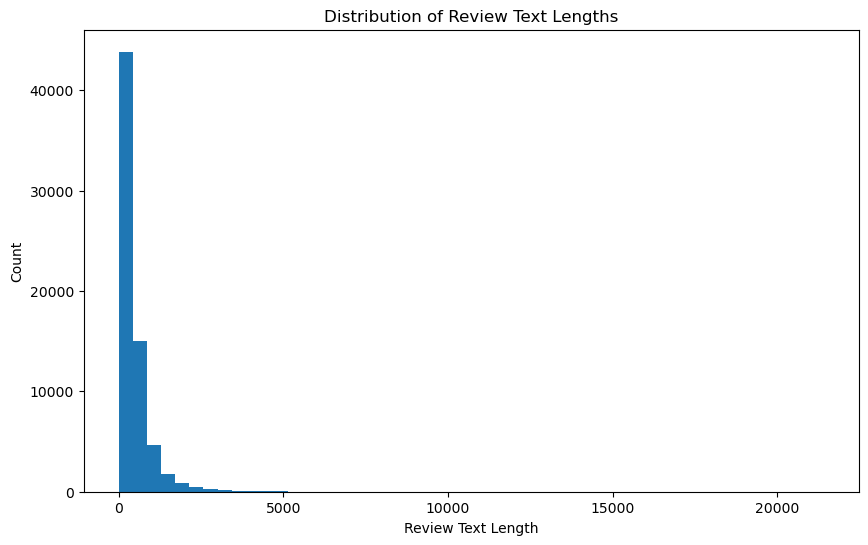

In [9]:
import matplotlib.pyplot as plt

review_lengths = df.select('reviewText_length').rdd.flatMap(lambda x: x).collect()

# Now convert this list to a Pandas Series
pd_series = pd.Series(review_lengths)

# Plotting the distribution of reviewText_length using Pandas/Matplotlib
plt.figure(figsize=(10, 6))
pd_series.hist(bins=50)  # Adjust the number of bins for your specific dataset
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Text Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()

In [10]:
# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold

df = df.filter(col('reviewText_length') < 1000)  # Example threshold

In [11]:
# Text Processing - cleaning the review text, tokenizing, and removing stop words (simplified example)
from pyspark.ml.feature import Tokenizer, StopWordsRemover
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
df = tokenizer.transform(df)
remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
df = remover.transform(df)

In [12]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{null, null, null...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{null, null, null...|             Creased|    1402272000|    t

In [13]:
from pyspark.sql.functions import when, col, length, split

# Split reviewTime into day, month, and year
split_col = split(df['reviewTime'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1).substr(0,2))
df = df.withColumn('Year', split_col.getItem(2))
df = df.drop('reviewTime')

# Convert 'vote' to integer type
df = df.withColumn('vote', df['vote'].cast('int'))

In [ ]:
df.show(10)

In [ ]:
df.select('reviewerName').distinct().count()

In [ ]:
df.select('asin').distinct().count()

In [ ]:
from pyspark.sql.functions import avg, count

# Average rating
average_rating = df.agg(avg("overall")).first()[0]

# Count of reviews for each asin
reviews_per_asin = df.groupBy("asin").agg(count("reviewerID").alias("Number_of_Reviews"))

# Summary for vote column
votes_summary = df.describe(['vote'])



In [ ]:
# Count of reviews for each reviewer
reviews_per_reviewers = df.groupBy("reviewerID").agg(count("asin").alias("Number_of_Reviews"))

In [ ]:
votes_summary

In [ ]:


# Convert Spark DataFrame to Pandas for Visualization
pdf = df.toPandas()
reviews_per_asin_pdf = reviews_per_asin.toPandas()

# Histogram for overall ratings
plt.figure(figsize=(10, 6))
pdf['overall'].hist()
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Plotting the pie chart for overall ratings
rating_counts = pdf['overall'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




In [ ]:

# Bar chart for number of reviews for each asin
top_reviews_per_asin_pdf = reviews_per_asin_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'asin' as the index and plot the 'review_count' column
top_reviews_per_asin_pdf.set_index('asin')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 ASINs')
plt.ylabel('Count')
plt.xlabel('ASIN')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Bar chart for number of reviews for each reviewers
reviews_per_reviewers_pdf = reviews_per_reviewers.toPandas()

top_reviews_per_reviewers_pdf = reviews_per_reviewers_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'reviewers' as the index and plot the 'review_count' column
top_reviews_per_reviewers_pdf.set_index('reviewerID')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 reviewers')
plt.ylabel('Count')
plt.xlabel('reviewers')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Convert reviewText and summary columns to a single string
review_text_str = ' '.join(df.rdd.map(lambda row: row.reviewText).collect())
summary_str = ' '.join(df.rdd.map(lambda row: row.summary).collect())

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(review_text_str, "Word Cloud for Review Text")
generate_word_cloud(summary_str, "Word Cloud for Summary")


# Modelling

## Data Splitting

In [11]:

from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(df).transform(df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)

(train, test) = df.randomSplit([0.8, 0.2])


## ALS

refer: https://www.kaggle.com/code/nadianizam/h-m-fashion-recommendation-with-pyspark



In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall", coldStartStrategy="drop")

# Fitting the ALS model on the training data
model = als.fit(train)

# Predicting on the train and test sets
predictions_train = model.transform(train)
predictions_test = model.transform(test)

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Evaluate the model on training data
rmse_train = reg_evaluator.evaluate(predictions_train)

# Evaluate the model on test data
rmse_test = reg_evaluator.evaluate(predictions_test)


In [ ]:
rmse_train

In [ ]:
rmse_test

## GraphFrame

In [15]:
!pip install graphframes

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.0 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [17]:
from graphframes import GraphFrame

# Assuming 'df' is your original PySpark DataFrame and it has been indexed
# Create vertices DataFrame
vertices = df.selectExpr("userIndex as id").distinct().union(df.selectExpr("itemIndex as id").distinct()) # check if those two index overlap

# Create edges DataFrame
edges = df.selectExpr("userIndex as src", "itemIndex as dst", "overall as rating")

# Create a GraphFrame
graph = GraphFrame(vertices, edges)

ModuleNotFoundError: No module named 'graphframes'

In [ ]:
# TO DO
# 1: Hyperparameter tuning
# 2: How to make use of the graph functions?

# Content-based Filtering

In [18]:
df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [19]:
df_meta.groupBy('price').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               price|count|
+--------------------+-----+
|                    |42683|
|.a-box-inner{back...| 1064|
|               $9.99|  953|
|               $7.99|  793|
|               $8.99|  666|
|               $6.99|  650|
|              $14.99|  647|
|              $19.99|  639|
|              $12.99|  621|
|              $15.99|  518|
|              $11.99|  516|
|               $5.99|  515|
|               $1.41|  498|
|              $13.99|  482|
|               $9.95|  478|
|              $10.99|  467|
|               $4.99|  467|
|              $29.99|  449|
|              $16.99|  399|
|              $12.95|  365|
+--------------------+-----+
only showing top 20 rows



In [20]:
df_meta.groupBy('brand').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               brand|count|
+--------------------+-----+
|              uxcell| 7147|
|         Small Parts| 4252|
|   The Hillman Group| 1868|
|                    | 1302|
|           SmartSign| 1164|
|                  3M| 1021|
|                 VXB| 1003|
|               Brady|  866|
|     ComplianceSigns|  793|
|Hard-to-Find Fast...|  700|
|                SEOH|  680|
|   RAW PRODUCTS CORP|  660|
|           Fastenere|  608|
|             Generic|  582|
|              Vestil|  573|
|      D&D PowerDrive|  568|
|             Medline|  560|
|  Simpson Strong-Tie|  492|
|               EISCO|  487|
|             Hillman|  458|
+--------------------+-----+
only showing top 20 rows



In [12]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F
from pyspark.sql.functions import mean
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

# Step 1: The item profiles are already in 'df_transformed' as 'features'

from pyspark.sql.functions import avg, count, collect_list
from pyspark.sql.window import Window

# Replace null or empty strings with a placeholder
df_meta = df_meta.na.fill({"brand": "Unknown"})
df_meta = df_meta.withColumn("brand", F.when(F.col("brand") == "", "Unknown").otherwise(F.col("brand")))

# Step 1: Remove the dollar sign and try to convert the price to float
df_meta = df_meta.withColumn("price", regexp_replace(col("price"), "[\$,]", "").cast("float"))

# Step 2: Replace non-numeric (or negative) values with None, which Spark recognizes as null
df_meta = df_meta.withColumn("price", when(col("price") < 0, None).otherwise(col("price")))

# Step 3: Calculate the average of the numeric prices
average_price = df_meta.select(avg(col("price")).alias("avg_price")).collect()[0]["avg_price"]

# Step 4: Fill null values with the average price
df_meta = df_meta.na.fill({"price": average_price})


# Ensure the 'brand' column exists and does not have empty strings or null values
if 'brand' not in df_meta.columns:
    raise ValueError("'brand' column is missing from the DataFrame.")
if df_meta.filter((col('brand') == "") | (col('brand').isNull())).count() > 0:
    raise ValueError("'brand' column contains null or empty strings.")

# Ensure the 'price' column exists and has the correct data type
if 'price' not in df_meta.columns:
    raise ValueError("'price' column is missing from the DataFrame.")
if df_meta.filter(col('price').isNull()).count() > 0:
    df_meta = df_meta.fillna({'price': 0})  # Replace nulls with 0 in 'price' column

In [ ]:
df_meta.select('brand').distinct().count()

In [ ]:
df_meta.groupBy('brand').count().orderBy(col('count').desc()).show()

In [16]:
# Assuming 'train' and 'test' are the DataFrames resulting from splitting 'df',
# and 'df_meta' is the DataFrame containing the metadata

# Select the 'asin' from train and test DataFrames
train_asin = train.select('asin').distinct()
test_asin = test.select('asin').distinct()

# Join the metadata with the asin DataFrames to filter the rows
df_train = df_meta.join(train_asin, on='asin', how='inner')
df_test = df_meta.join(test_asin, on='asin', how='inner')

# Now df_train_meta and df_test_meta contain metadata for asins in the train and test sets respectively


In [17]:
# Convert the 'price' column into a vector column
assembler_for_price = VectorAssembler(inputCols=["price"], outputCol="price_vector")

# Normalize the price column
price_scaler = MinMaxScaler(inputCol="price_vector", outputCol="price_scaled")

# Define the pipeline with all the stages
pipeline = Pipeline(stages=[
    # brand_indexer,
    # brand_encoder,
    assembler_for_price,
    price_scaler
    # assembler_for_features
])

# After cleaning, try fitting the pipeline again
pipeline_model = pipeline.fit(df_train)

# Now transform the data
df_transformed = pipeline_model.transform(df_train)

# Show the result
df_transformed.show()



23/11/08 00:27:21 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 00:27:32 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 00:27:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 00:27:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 00:27:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|      asin|            also_buy|           also_view|               brand|            category|              date|         description|             details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat|   price|                rank|        similar_item|               tech1|tech2|               title|        price_vector|        price_scaled|
+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--

In [31]:
def calculate_similarity(user_brand, user_avg_price, item_brand, item_price):
    # Simple similarity based on brand matching and price difference
    brand_similarity = 1 if user_brand == item_brand else 0
    # Prevent division by zero if user_avg_price is 0
    price_similarity = 1 - abs(item_price - user_avg_price) / user_avg_price if user_avg_price != 0 else 0
    # Combine the two components of similarity
    return brand_similarity * 0.5 + price_similarity * 0.5
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, count, col, broadcast

df_train = df_transformed

# Prepare the item profiles from the training set
item_profiles_train = df_train.select('asin', 'brand', 'price').distinct()

# Calculate the average price for each user in the training set
avg_price_train = train.join(df_train, 'asin').groupBy('reviewerID').agg(avg('price').alias('avg_price'))

# Count the occurrences of each brand for each user in the training set and find the most frequent one
brand_frequency_train = train.join(df_train, 'asin').groupBy('reviewerID', 'brand').agg(count('brand').alias('brand_count'))

# Find the top brand for each user in the training set
windowSpec = Window.partitionBy('reviewerID').orderBy(col('brand_count').desc(), col('brand'))
top_brands_train = (brand_frequency_train.withColumn('rank', F.row_number().over(windowSpec))
                    .where(col('rank') == 1)
                    .select('reviewerID', 'brand'))

# Create the user profiles using the training set
user_profiles_train = avg_price_train.join(broadcast(top_brands_train), 'reviewerID')

user_profiles_train.show(10)

23/11/08 08:31:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:31:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:31:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:31:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:31:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:31:34 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:31:34 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+--------------+------------------+--------------+
|    reviewerID|         avg_price|         brand|
+--------------+------------------+--------------+
|A1XSLKDHJVS9WT|3.9800000190734863|    Frost King|
|A3LS2HKRVRYK9Q|132.49000549316406|           Jet|
| A1M97ZR8OPE3I| 94.81333669026692|           Jet|
| A5KBLLLHVL65K| 3.990000009536743|Hy-Ko Products|
| AKH1CEX3TGZGP| 3.990000009536743|Hy-Ko Products|
|A1LG0RB22GV3QY| 27.16999626159668|        Geocel|
| AF3AZVK90T805| 59.06998825073242|      J-B Weld|
|A1XKVW78IIGXP0| 59.06998825073242|      J-B Weld|
|A2GN2Y3M2Q9XNX| 57.61000061035156|      Shop-Vac|
|A2FSU0FOYLVBU3| 57.61000061035156|      Shop-Vac|
+--------------+------------------+--------------+
only showing top 10 rows



23/11/08 08:31:34 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


In [32]:
item_profiles_train.show(10)

23/11/08 08:32:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:32:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:32:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+----------+--------------------+------+
|      asin|               brand| price|
+----------+--------------------+------+
|B00004SZ5J|         Irwin Tools| 64.59|
|B00004T7W2|General Tools Mfg...|  5.58|
|B00004XPVN|              Wilton|122.92|
|B00004Z2HD|      ARROW FASTENER|  2.46|
|B00007JQQI|       Master Caster|   6.2|
|B00008IHTK|            Starrett|268.93|
|B0002XRM4W|     ISC Racers Tape| 15.45|
|B0002YUNRE|      Gardner Bender|  5.45|
|B0002YWNLS|               Eagle|  4.59|
|B0008JIQVI|            Shop-Vac| 57.61|
+----------+--------------------+------+
only showing top 10 rows



23/11/08 08:32:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


In [33]:
.show()

23/11/08 08:38:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:38:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:38:21 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:38:30 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:38:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:38:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:38:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:38:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:38:36 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


+--------------+------------------+------------------+
|    reviewerID|         avg_price|             brand|
+--------------+------------------+------------------+
|A32FZPORDRP3A3| 4.949999809265137|          BOSTITCH|
| AHMI8DQJJMB49|17.309999465942383|             Omron|
| ARH2FYMMOXFB5| 9.260000228881836| The Hillman Group|
|A1AUYOLJHUBFY1|21.427997636795045|    Gardner Bender|
| ARM3HEO1D67NF| 5.710000038146973|       Install Bay|
|A29QEUREQ9OMAA| 59.06998825073242|       Small Parts|
| AY68U1SJ0UB8B|  4.46999979019165|        Quakehold!|
|A3R1N4BRAH1S61| 67.44499969482422|   MDF Instruments|
| A3SWMTPJNHWUM|10.010000228881836|           Dynarex|
|A30VD61TSFUZVJ| 59.06998825073242|           Unknown|
|A1K344MWYUQ24A|15.699999809265137|               ADC|
| A1XQZ84K9JCGL|137.23000462849936|             Fluke|
|A2Y64L1IFG2MVH| 59.06998825073242|               ARB|
|A119TAKX9W6FLM| 59.06998825073242|             Valeo|
|A20YQUOOUKMEYM| 59.06998825073242|   MDF Instruments|
|A1AGCZQPZ

23/11/08 08:38:37 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


In [34]:

# Register the UDF
similarity_udf = F.udf(calculate_similarity, FloatType())

# Generate recommendations for users in the validation set
# First, get the list of items each user has reviewed in the training set to exclude them from recommendations
df_already_reviewed_train = train.select('reviewerID', 'asin').distinct().alias("ar_train")

# Calculate similarities between user profiles and item profiles, excluding already reviewed items
user_profiles_val = test.select('reviewerID').distinct().alias("up_val")
item_profiles_alias = item_profiles_train.alias("ip")

user_profiles_val = user_profiles_val.join(broadcast(user_profiles_train), "reviewerID", "inner")
user_profiles_val = user_profiles_val.alias("up_val")
user_item_similarity = (user_profiles_val
                        .crossJoin(broadcast(item_profiles_alias))
                        .withColumn('similarity', similarity_udf(
                            col('up_val.brand'), col('up_val.avg_price'), col('ip.brand'), col('ip.price')))
                        .select('up_val.reviewerID', 'ip.asin', 'similarity'))

recommendations = (user_item_similarity.join(df_already_reviewed_train,
                                             (user_item_similarity.reviewerID == df_already_reviewed_train.reviewerID) &
                                             (user_item_similarity.asin == df_already_reviewed_train.asin), 'left_anti')
                   .groupBy('reviewerID')
                   .agg(expr('collect_list(struct(asin, similarity)) as recommendations')))




In [35]:
user_item_similarity.show(10)

23/11/08 08:40:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:40:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:40:59 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:14 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/11/08 08:41:14 WARN DAGScheduler: Broadcasting larg

+--------------+----------+----------+
|    reviewerID|      asin|similarity|
+--------------+----------+----------+
|A32FZPORDRP3A3|B00004SZ5J|-5.5242424|
|A32FZPORDRP3A3|B00004T7W2| 0.4363636|
|A32FZPORDRP3A3|B00004XPVN|-11.416162|
|A32FZPORDRP3A3|B00004Z2HD|0.24848486|
|A32FZPORDRP3A3|B00007JQQI|0.37373737|
|A32FZPORDRP3A3|B00008IHTK|-26.164646|
|A32FZPORDRP3A3|B0002XRM4W|-0.5606061|
|A32FZPORDRP3A3|B0002YUNRE|0.44949496|
|A32FZPORDRP3A3|B0002YWNLS| 0.4636364|
|A32FZPORDRP3A3|B0008JIQVI|-4.8191924|
+--------------+----------+----------+
only showing top 10 rows



In [36]:
recommendations.show(10)

23/11/08 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:30 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 08:41:33 WARN DAGScheduler: Broadcasting larg

+--------------+--------------------+
|    reviewerID|     recommendations|
+--------------+--------------------+
|A10AY74351AJSG|[{B00004SZ5J, 0.4...|
|A10O7THJ2O20AG|[{B00004SZ5J, -0....|
|A10SSEK4KB0SMD|[{B00004SZ5J, 0.4...|
|A10Z8K7CVE3VHZ|[{B00004SZ5J, -5....|
|A10ZFE6YE0UHW8|[{B00004SZ5J, -0....|
|A119TAKX9W6FLM|[{B00004SZ5J, 0.4...|
|A11JI4CX8C84OT|[{B00004SZ5J, -3....|
|A12EEGO26GHBAY|[{B00004SZ5J, 0.4...|
|A12JE5QXN10IO1|[{B00004SZ5J, -3....|
|A132JF54KQKAKH|[{B00004SZ5J, -2....|
+--------------+--------------------+
only showing top 10 rows



In [40]:
# Sort and get top N recommendations for each user
top_n = 1  # Assuming we want the top 1 recommendations
get_top_n = F.udf(lambda recs: sorted(recs, key=lambda x: x[1], reverse=True)[:top_n], ArrayType(StructType()))
final_recommendations = (recommendations
                         .withColumn('top_recommendations', get_top_n(col('recommendations')))
                         .select('reviewerID', 'top_recommendations'))

In [41]:
# Show the final recommendations
final_recommendations.show(truncate=False)

23/11/08 09:02:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:25 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:25 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:32 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/08 09:02:32 WARN DAGScheduler: Broadcasting larg

Py4JJavaError: An error occurred while calling o1060.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 194.0 failed 1 times, most recent failure: Lost task 0.0 in stage 194.0 (TID 118) (udc-aw34-17c0 executor driver): java.lang.IllegalStateException: Input row doesn't have expected number of values required by the schema. 0 fields are required while 2 values are provided.
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$16$1.applyOrElse(EvaluatePython.scala:188)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:213)
	at org.apache.spark.sql.execution.python.EvaluatePython$.$anonfun$makeFromJava$16(EvaluatePython.scala:182)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$13$1.$anonfun$applyOrElse$1(EvaluatePython.scala:162)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$13$1.applyOrElse(EvaluatePython.scala:162)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:213)
	at org.apache.spark.sql.execution.python.EvaluatePython$.$anonfun$makeFromJava$13(EvaluatePython.scala:160)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$7(BatchEvalPythonExec.scala:101)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage23.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:354)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:382)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:354)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4177)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3382)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:284)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:323)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalStateException: Input row doesn't have expected number of values required by the schema. 0 fields are required while 2 values are provided.
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$16$1.applyOrElse(EvaluatePython.scala:188)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:213)
	at org.apache.spark.sql.execution.python.EvaluatePython$.$anonfun$makeFromJava$16(EvaluatePython.scala:182)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$13$1.$anonfun$applyOrElse$1(EvaluatePython.scala:162)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$13$1.applyOrElse(EvaluatePython.scala:162)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:213)
	at org.apache.spark.sql.execution.python.EvaluatePython$.$anonfun$makeFromJava$13(EvaluatePython.scala:160)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$7(BatchEvalPythonExec.scala:101)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage23.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
